4. Análise/exploração dos dados

Com `final_df` exportado para um arquivo .CSV, a etapa de análise dos dados pode utilizá-lo para começar a descrever e comparar as informações.
Começamos com algumas hipóteses simples:

a)	Altos preços médios de gasolina resultam em uma redução na quantidade de entregas;

b)	Baixos preços médios de gasolina resultam em maiores distâncias de entrega efetuadas;

c)	Os dias da semana têm relevância para a variação do número de pedidos.

In [163]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Importa o dataframe com base no csv após processamento:
final_df = pd.read_csv('final_df.csv')
final_df

,delivery_order_id,order_date,paused_time_minutes,speed_time_minutes,transit_time_minutes,delivery_distance_meters,city,state,date_range_id,product,average_retail_price
0,68412721,2021-01-01,10.22,11.05,83.30,5714.0,SÃO PAULO,SP,1,GASOLINA COMUM,4.235
1,68413340,2021-01-01,3.10,12.67,49.78,5199.0,SÃO PAULO,SP,1,GASOLINA COMUM,4.235
2,68414018,2021-01-01,3.03,13.28,11.05,3746.0,SÃO PAULO,SP,1,GASOLINA COMUM,4.235
3,68414512,2021-01-01,39.75,39.85,23.82,5514.0,SÃO PAULO,SP,1,GASOLINA COMUM,4.235
4,68415344,2021-01-01,28.83,29.38,53.08,5385.0,SÃO PAULO,SP,1,GASOLINA COMUM,4.235
...,...,...,...,...,...,...,...,...,...,...,...
218199,93139799,2021-04-30,1.87,4.18,13.22,2911.0,CURITIBA,PR,18,GASOLINA COMUM,5.311
218200,93139802,2021-04-30,0.63,4.05,21.80,1489.0,SÃO PAULO,SP,18,GASOLINA COMUM,5.265
218201,93139805,2021-04-30,3.52,9.68,5.83,475.0,SÃO PAULO,SP,18,GASOLINA COMUM,5.265
218202,93139809,2021-04-30,3.48,9.62,20.67,3735.0,SÃO PAULO,SP,18,GASOLINA COMUM,5.265


4.1. Resumo Estatístico: Verificar média, mediana, mínimo, máximo e desvio padrão, especialmente para as colunas numéricas como `paused_time_minutes`, `speed_time_minutes`, `transit_time_minutes`, `delivery_distance_meters` e `average_retail_price`.

In [164]:
# Gera o resumo estatístico para as colunas numéricas:
statistic_summary = final_df[['paused_time_minutes', 'speed_time_minutes', 'transit_time_minutes', 
                               'delivery_distance_meters', 'average_retail_price']].describe()
statistic_summary

,paused_time_minutes,speed_time_minutes,transit_time_minutes,delivery_distance_meters,average_retail_price
count,218204.000000,218204.000000,218204.000000,2.182040e+05,218204.000000
mean,11.183980,16.201902,59.857818,3.063483e+03,5.237710
std,77.846753,80.780316,1119.161526,7.984240e+03,0.510902
min,0.000000,0.150000,0.000000,0.000000e+00,4.172000
25%,1.180000,4.600000,12.000000,1.703000e+03,4.984000
50%,2.580000,6.830000,16.930000,2.547000e+03,5.223000
75%,5.870000,11.000000,24.930000,3.814000e+03,5.531000
max,11712.280000,11718.200000,154261.100000,2.167005e+06,6.131000


4.2. Distribuição Temporal: Observar a distribuição das entregas ao longo do tempo (`order_date`), possivelmente detectar padrões sazonais e variações semanais, ou mesmo correlacionar picos e quedas com mudanças no preço da gasolina.

In [165]:
# Conta quantas entregas foram feitas por dia:
deliveries_by_date = final_df.groupby('order_date').size()
deliveries_by_date

order_date
2021-01-01     668
2021-01-02    1469
2021-01-03    1801
2021-01-04    1168
2021-01-05    1128
              ... 
2021-04-26    1515
2021-04-27    1513
2021-04-28    1640
2021-04-29    1821
2021-04-30    2038
Length: 120, dtype: int64

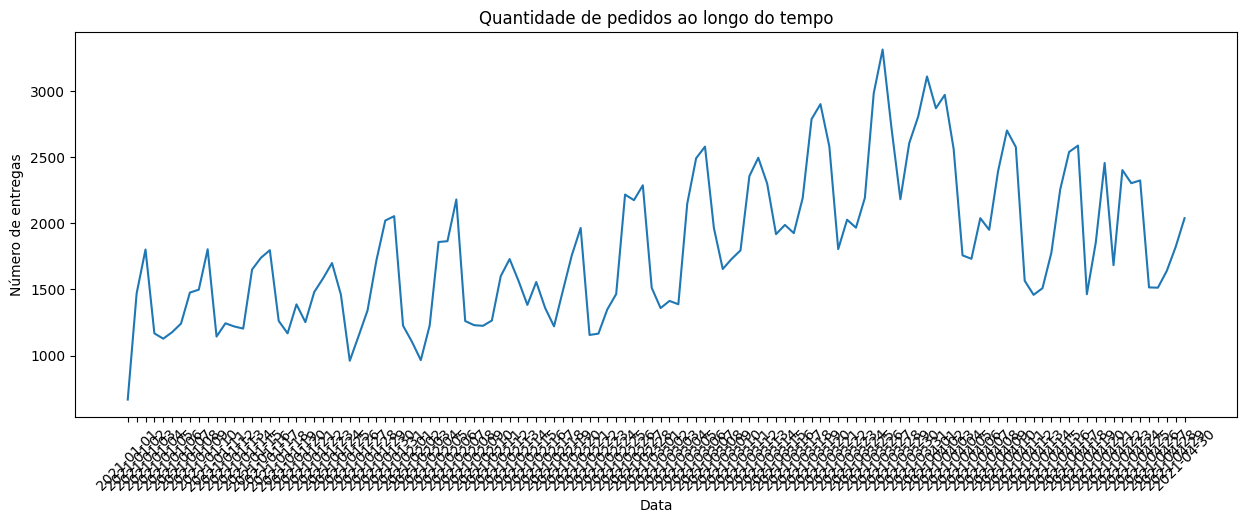

In [166]:
# Visualiza a distribuição de entregas ao longo do tempo:
plt.figure(figsize=(15, 5))
plt.plot(deliveries_by_date.index, deliveries_by_date.values)
plt.xlabel('Data')
plt.ylabel('Número de entregas')
plt.title('Quantidade de pedidos ao longo do tempo')
plt.xticks(rotation=45)
plt.show()

# Cria uma coluna para o dia da semana:
final_df['weekday'] = pd.to_datetime(final_df['order_date']).dt.dayofweek

In [178]:
final_df

,delivery_order_id,order_date,paused_time_minutes,speed_time_minutes,transit_time_minutes,delivery_distance_meters,city,state,date_range_id,product,average_retail_price,weekday
0,68412721,2021-01-01,10.22,11.05,83.30,5714.0,SÃO PAULO,SP,1,GASOLINA COMUM,4.235,4
1,68413340,2021-01-01,3.10,12.67,49.78,5199.0,SÃO PAULO,SP,1,GASOLINA COMUM,4.235,4
2,68414018,2021-01-01,3.03,13.28,11.05,3746.0,SÃO PAULO,SP,1,GASOLINA COMUM,4.235,4
3,68414512,2021-01-01,39.75,39.85,23.82,5514.0,SÃO PAULO,SP,1,GASOLINA COMUM,4.235,4
4,68415344,2021-01-01,28.83,29.38,53.08,5385.0,SÃO PAULO,SP,1,GASOLINA COMUM,4.235,4
...,...,...,...,...,...,...,...,...,...,...,...,...
218199,93139799,2021-04-30,1.87,4.18,13.22,2911.0,CURITIBA,PR,18,GASOLINA COMUM,5.311,4
218200,93139802,2021-04-30,0.63,4.05,21.80,1489.0,SÃO PAULO,SP,18,GASOLINA COMUM,5.265,4
218201,93139805,2021-04-30,3.52,9.68,5.83,475.0,SÃO PAULO,SP,18,GASOLINA COMUM,5.265,4
218202,93139809,2021-04-30,3.48,9.62,20.67,3735.0,SÃO PAULO,SP,18,GASOLINA COMUM,5.265,4


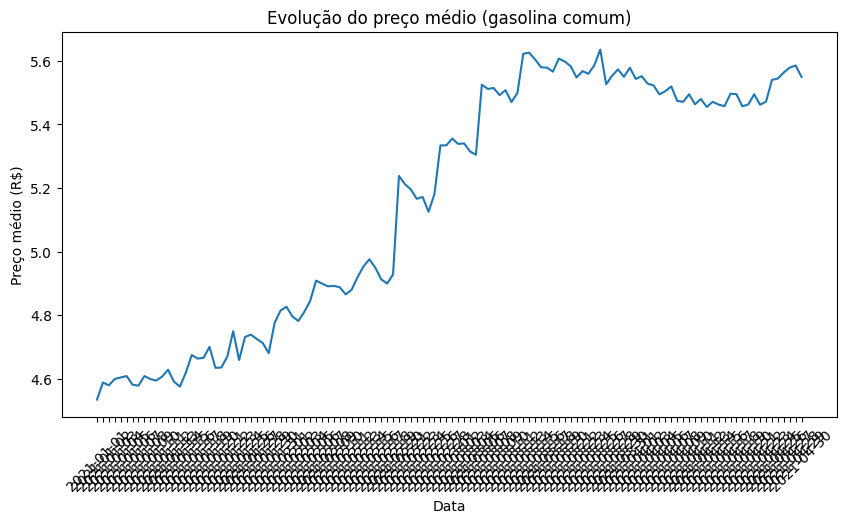

In [167]:
# Visualiza a evolução do preço médio ao longo do tempo:
avg_price_by_date = final_df.groupby('order_date')['average_retail_price'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=avg_price_by_date.index, y=avg_price_by_date.values)
plt.title(f"Evolução do preço médio (gasolina comum)")
plt.xlabel("Data")
plt.xticks(rotation=45)
plt.ylabel("Preço médio (R$)")
plt.show()

4.3. Validação de outliers: Identificar valores fora do intervalo interquartil (IQR), visualizados como pontos extremos em relação ao corpo principal dos dados no gráfico, a fim de a detectar anomalias que podem distorcer análises subsequentes ou a modelagem preditiva.

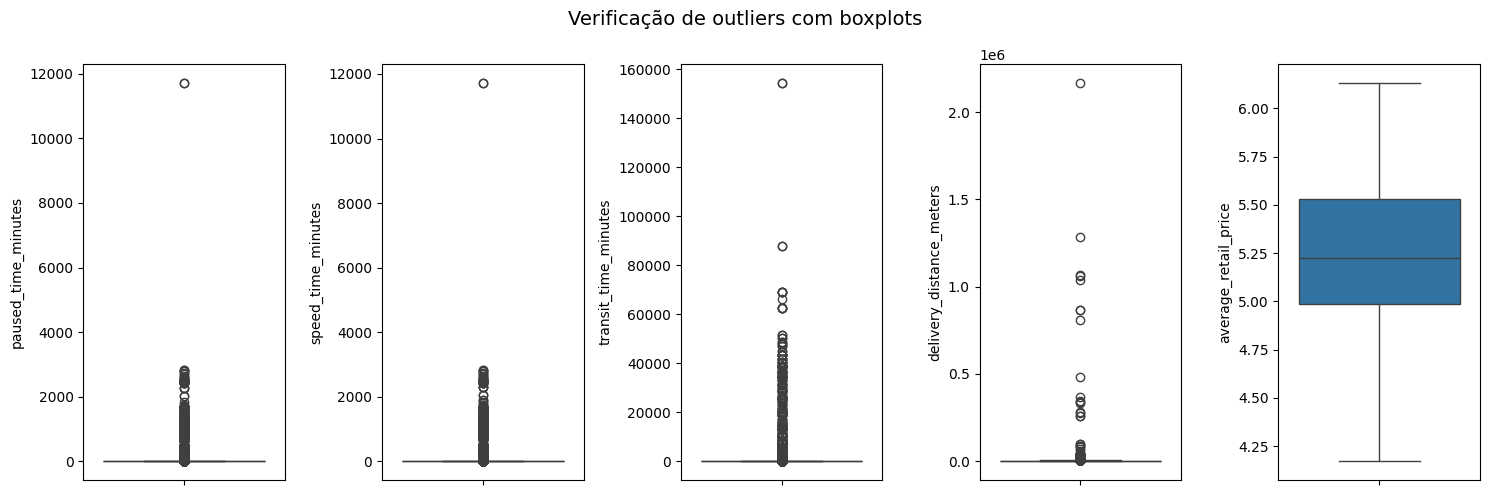

In [168]:
# Lista de variáveis para verificar outliers:
variables_to_check = ['paused_time_minutes', 'speed_time_minutes', 'transit_time_minutes', 'delivery_distance_meters', 'average_retail_price']

# Gera um boxplot para cada variável:
plt.figure(figsize=(15, 5))
plt.suptitle('Verificação de outliers com boxplots', fontsize=14)
for i, variable in enumerate(variables_to_check, 1):
    plt.subplot(1, len(variables_to_check), i)
    sns.boxplot(y=final_df[variable])
plt.tight_layout()
plt.show()

In [169]:
# Define um dicionário para armazenar máscaras de outliers para cada variável relevante:
outlier_masks = {}

for variable in variables_to_check:
    Q1 = final_df[variable].quantile(0.25)
    Q3 = final_df[variable].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_masks[variable] = (final_df[variable] < lower_bound) | (final_df[variable] > upper_bound)

for var, mask in outlier_masks.items():
    print(f"Outlier mask for {var}:")
    print(mask)
    print("\n")


Outlier mask for paused_time_minutes:
0         False
1         False
2         False
3          True
4          True
          ...  
218199    False
218200    False
218201    False
218202    False
218203    False
Name: paused_time_minutes, Length: 218204, dtype: bool


Outlier mask for speed_time_minutes:
0         False
1         False
2         False
3          True
4          True
          ...  
218199    False
218200    False
218201    False
218202    False
218203    False
Name: speed_time_minutes, Length: 218204, dtype: bool


Outlier mask for transit_time_minutes:
0          True
1          True
2         False
3         False
4          True
          ...  
218199    False
218200    False
218201    False
218202    False
218203    False
Name: transit_time_minutes, Length: 218204, dtype: bool


Outlier mask for delivery_distance_meters:
0         False
1         False
2         False
3         False
4         False
          ...  
218199    False
218200    False
218201    False


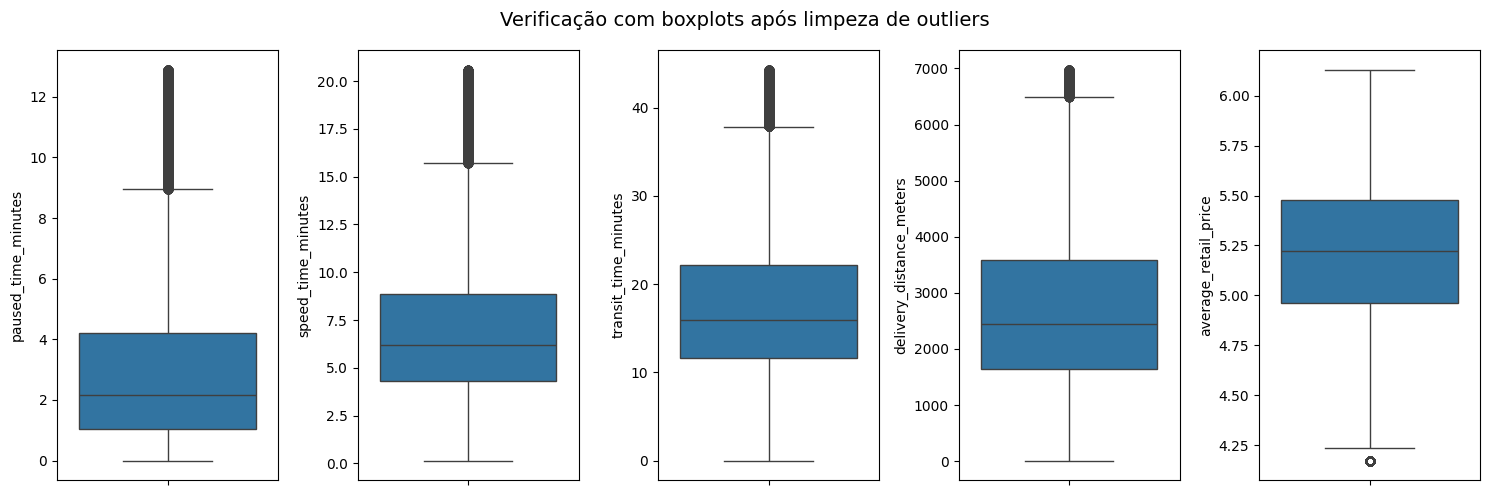

In [170]:
# Combina todas as máscaras de outliers:
combined_mask = outlier_masks[variables_to_check[0]]
for variable in variables_to_check[1:]:
    combined_mask |= outlier_masks[variable]

# Cria um novo dataframe, removendo os outliers, e o exporta para csv:
cleaned_df = final_df[~combined_mask]
cleaned_df.to_csv('cleaned_df.csv', index=False)

# Nova verificação de outliers após limpeza:
variables_to_check = ['paused_time_minutes', 'speed_time_minutes', 'transit_time_minutes', 'delivery_distance_meters', 'average_retail_price']
plt.figure(figsize=(15, 5))
plt.suptitle('Verificação com boxplots após limpeza de outliers', fontsize=14)
for i, variable in enumerate(variables_to_check, 1):
    plt.subplot(1, len(variables_to_check), i)
    sns.boxplot(y=cleaned_df[variable])
plt.tight_layout()
plt.show()

4.4. Matriz de correlação: Para análise de correlação, criamos o dataframe `aggregated_df`, onde a coluna `delivery_order_id` foi agrupada, por dia e por cidade, na nova coluna `delivery_order_count`. Esta, junto à coluna de `weekday`, foi analisada em comparação com as demais colunas numéricas já citadas, de modo a identificar padrões de interdependência e possível correlação.

In [171]:
# Agrega o total de pedidos por dia e cidade, considerando delivery_order_ids únicos:
aggregated_df = final_df.groupby(['order_date', 'city']).agg(
    delivery_order_count=('delivery_order_id', 'nunique'),
    paused_time_minutes=('paused_time_minutes', 'mean'),
    speed_time_minutes=('speed_time_minutes', 'mean'),
    transit_time_minutes=('transit_time_minutes', 'mean'),
    delivery_distance_meters=('delivery_distance_meters', 'mean'),
    average_retail_price=('average_retail_price', 'mean'),
    weekday=('weekday', 'first'),
    product=('product', 'first'),
    state=('state', 'first')
).reset_index()

# Imprime o novo dataframe e o exporta para csv:
aggregated_df.to_csv('aggregated_df.csv', index=False)
aggregated_df

,order_date,city,delivery_order_count,paused_time_minutes,speed_time_minutes,transit_time_minutes,delivery_distance_meters,average_retail_price,weekday,product,state
0,2021-01-01,CURITIBA,12,0.762500,4.155000,11.009167,2709.416667,4.172,4,GASOLINA COMUM,PR
1,2021-01-01,PORTO ALEGRE,77,4.979753,7.069877,19.681852,3426.333333,4.626,4,GASOLINA COMUM,RS
2,2021-01-01,RIO DE JANEIRO,217,3.880779,7.315281,20.144026,2704.995671,4.968,4,GASOLINA COMUM,RJ
3,2021-01-01,SÃO PAULO,305,11.552849,15.456395,28.905843,3042.404070,4.235,4,GASOLINA COMUM,SP
4,2021-01-02,CURITIBA,156,2.226875,6.645500,13.062813,2914.125000,4.172,5,GASOLINA COMUM,PR
...,...,...,...,...,...,...,...,...,...,...,...
475,2021-04-29,SÃO PAULO,848,6.425263,11.458619,21.194030,3093.800228,5.265,3,GASOLINA COMUM,SP
476,2021-04-30,CURITIBA,167,2.140520,6.640116,14.053584,2804.543353,5.311,4,GASOLINA COMUM,PR
477,2021-04-30,PORTO ALEGRE,255,2.166977,4.569651,17.334070,3389.387597,5.781,4,GASOLINA COMUM,RS
478,2021-04-30,RIO DE JANEIRO,497,4.069449,8.203137,22.055760,2690.323194,6.099,4,GASOLINA COMUM,RJ


In [172]:
# Seleciona apenas as colunas numéricas:
df_numerico = aggregated_df[['delivery_order_count','weekday','paused_time_minutes','speed_time_minutes','transit_time_minutes','delivery_distance_meters','average_retail_price']]

# Gera a matriz de correlação:
df_numerico.corr()

,delivery_order_count,weekday,paused_time_minutes,speed_time_minutes,transit_time_minutes,delivery_distance_meters,average_retail_price
delivery_order_count,1.000000,0.192423,0.490560,0.506560,0.073513,-0.145146,0.197158
weekday,0.192423,1.000000,-0.122066,-0.128405,-0.007152,-0.035047,-0.023033
paused_time_minutes,0.490560,-0.122066,1.000000,0.990909,0.038864,0.053984,0.078129
speed_time_minutes,0.506560,-0.128405,0.990909,1.000000,0.038266,0.054813,0.115453
transit_time_minutes,0.073513,-0.007152,0.038864,0.038266,1.000000,0.023381,0.036100
delivery_distance_meters,-0.145146,-0.035047,0.053984,0.054813,0.023381,1.000000,0.188286
average_retail_price,0.197158,-0.023033,0.078129,0.115453,0.036100,0.188286,1.000000


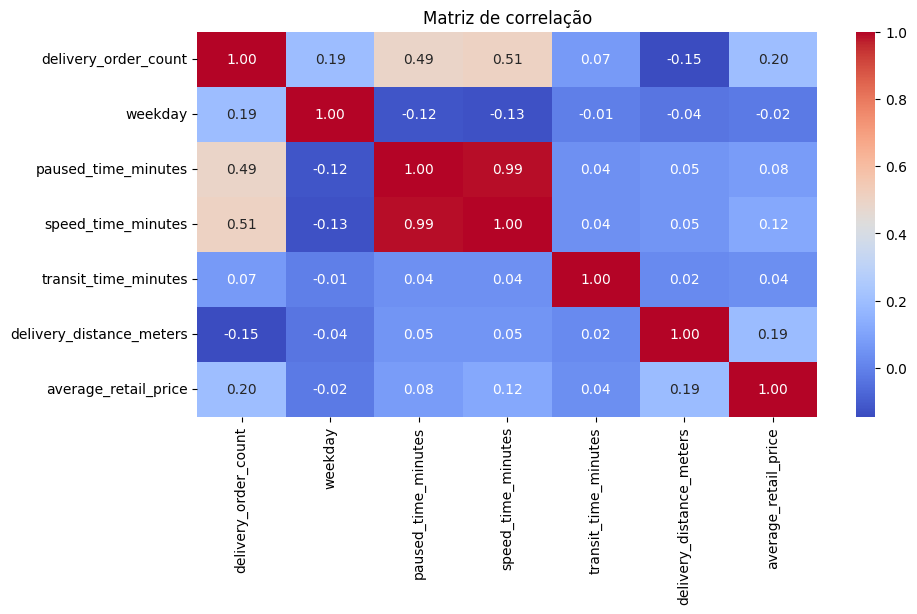

In [173]:
# Visualiza a matriz de correlação como mapa de calor:
plt.figure(figsize=(10, 5))
sns.heatmap(df_numerico.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlação")
plt.show()